In [1]:
import pandas as pd
import h5py
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import scipy
from scipy.stats import norm
import time
sns.set()

#working on a way to control the variance. right now i'm setting a max_variance. if its over
#then we use max variance is based on the largest value from the forecasts.

In [2]:
def CRPS(df_true, df_pred):
    """
    Input: df_true=vector of true values
    df_pred= probabalistic forecast from 0.01-.0.99 for each timestep
    """
    loss=0
    q=np.arange(.01, 1.0, .01)
    for i in range(df_true.shape[0]):#cycles through each timestep
        y=df_true[i] #true value at timestep "i"
        yhat=df_pred.iloc[i,:] #quantile prediction at timestep "i"
        #CRPS loss
        loss=loss+sum([(min(yhat)-y) if y<min(yhat) else 0, 
        np.trapz(q[yhat <= y]**2, yhat[yhat <= y]),
        np.trapz((q[yhat >= y]-1)**2, yhat[yhat >= y]),
        (y-max(yhat)) if y>max(yhat) else 0])

    return loss/df_true.shape[0] #average CRPS at each timestep

In [3]:
#True data
load_data_path="/lustre/eaglefs/projects/rjsolfor/NYISO/Data/Load_Data/"
BA='NYISO_BA'
zone_load_data=pd.read_csv(load_data_path + 'NYISO_ALL_ZONES_FILLED_Attenuated.csv',index_col=0)
zone_load_data=zone_load_data[:-1]
zone_load_data.index=pd.to_datetime(zone_load_data.index)
zone_load_data15min=zone_load_data.resample('15min').mean()
zone_load_data1hour=zone_load_data.resample('1H').mean()
zone_load_data15min[BA]=zone_load_data15min.values.sum(axis=1)
zone_load_data1hour[BA]=zone_load_data1hour.values.sum(axis=1)

CAPTIL
33.365718992285416
0.9686088527551943


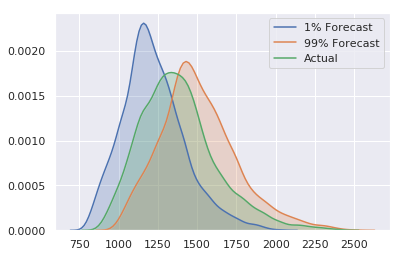

CENTRL
39.86059040046375
0.9840785907859079


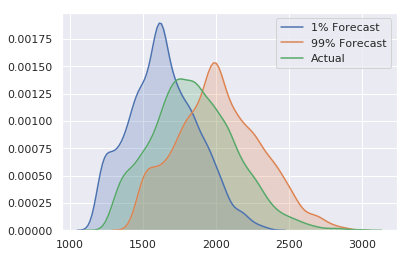

DUNWOD
17.987773952630256
0.9648825654923215


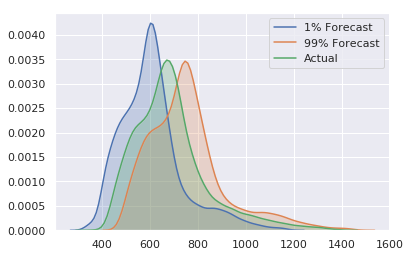

GENESE
25.640577585939525
0.9749322493224932


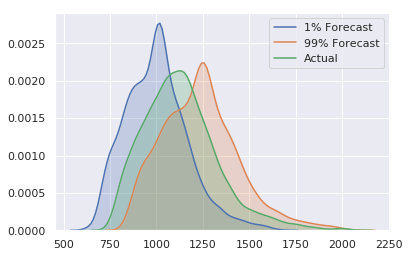

HUD VL
29.98654804386613
0.9551716350496838


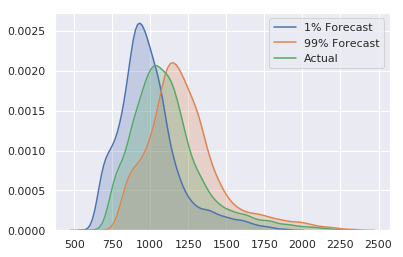

LONGIL
68.4320294599005
0.9474932249322493


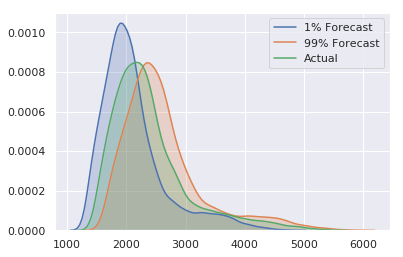

MHK VL
21.09492386752015
0.9785456187895212


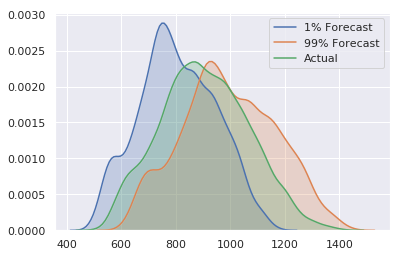

MILLWD
11.096212996831088
0.9198283649503162


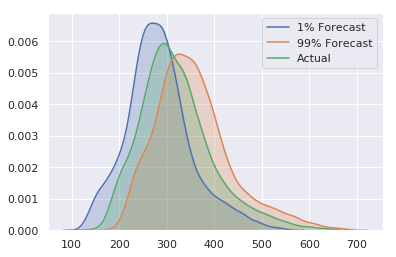

N.Y.C.
112.15584147451257
0.9853206865401988


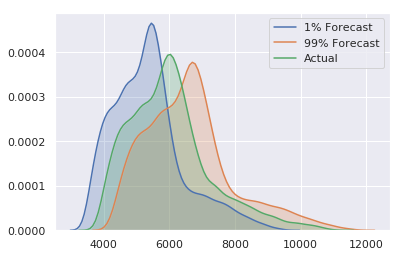

NORTH
13.63393280950856
0.9362014453477868


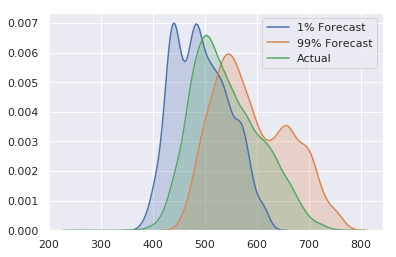

WEST
40.79092526773261
0.9812556458897922


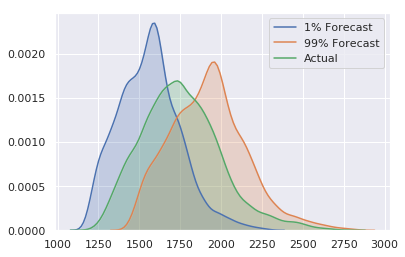

NYISO_BA
323.6893107956051
0.9914182475158085


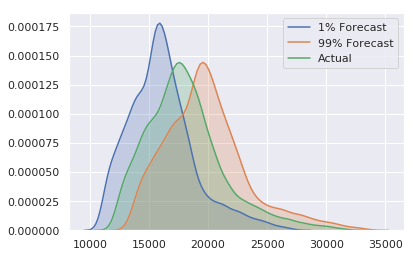

time elapsed:126.58689284324646


In [31]:
zone_names=['CAPTIL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL','MILLWD', 'N.Y.C.', 'NORTH', 'WEST', 'NYISO_BA']
start = time.time()
for z in zone_names:
    #z=zone_names[0]
    print(z)
    #gaussian z-score
    z_score=np.zeros((99,1))
    for i in range(1,100):
        a=i/100
        z_score[(i-1),]=scipy.stats.norm.ppf(a)
    #15min actuals
    a=[]
    zone=z
    for i in range(8844):
        a.append(zone_load_data1hour[zone][8671+i:8677+i].values)

    cols=[]
    dti=pd.date_range('2018-12-28 00:00:00',periods=8844, freq='1H')
    dti
    for i in range(7,13):
        cols.append("{}_n_steps_ahead".format(i))
    actual_1hour_load=pd.DataFrame(a,columns=cols, index=dti)
    var_max=max(actual_1hour_load["7_n_steps_ahead"])*.08/2.32 #.05 works well
    #load forecasts 
    cnn_data=[]
    rnn_data=[]
    cnn_metrics={"MAE":[],'RMSE':[],'MAPE':[],'MBE':[]}
    rnn_metrics={"MAE":[],'RMSE':[],'MAPE':[],'MBE':[]}
    for i in range(0,51):
        try:
            cnn_data.append(pd.read_csv('/lustre/eaglefs/projects/rjsolfor/NYISO/Load_Forecasts/Deterministic/{}/6H_CNN_ECMWF{}_Forceast.csv'.format(zone,i),index_col=0))
            cnn_data[i].index=pd.to_datetime(pd.date_range('2018-12-28 00:00:00',periods=8856, freq='1H'))
        except:
            pass
        try:
            rnn_data.append(pd.read_csv('/lustre/eaglefs/projects/rjsolfor/NYISO/Load_Forecasts/Deterministic/{}/6H_RNN_ECMWF{}_Forceast.csv'.format(zone,i),index_col=0))
            rnn_data[i].index=pd.to_datetime(pd.date_range('2018-12-28 00:00:00',periods=8856, freq='1H'))
        except:
            pass
    #this creates the dataframe for probabalistic horizon forecast 
    columns=['0.01']
    fil=0.01
    for k in range(98):
        fil=round(fil+.01,2)
        columns.append('{}'.format(fil))
    prob_forecast=pd.DataFrame(columns=columns, index=rnn_data[0].index)
    #below loop cycles through each horizon to create prob forecast
    #for c in actual_15min_load.columns:
    c='7_n_steps_ahead'
    horizon=c
    #number of ensemble members
    m_c=len(cnn_data)
    m_r=len(rnn_data)
    total_ensem=m_c+m_r
    #number of timesteps
    n=rnn_data[0].shape[0]
    #forecasts matrix and weights
    forecast_matrix=np.zeros((n,total_ensem))
    Variance=[]

    #creates a inidvidual forecast matrix for the horizon
    for i in range(0,m_c):
        forecast_matrix[:,i]=cnn_data[i][horizon]
    e_mem=0
    for j in range(m_c,total_ensem):
        forecast_matrix[:,j]=rnn_data[e_mem][horizon]
        e_mem=e_mem+1

    #loop cycles through each timestep to calculate mu and var for gaussian estimate
    for k in range(n):
        #each time steps weight adjustment
        det_point_forecast=forecast_matrix[k,:]
        mu=det_point_forecast.mean()
        cnn_var=np.std(det_point_forecast[0:m_c])**2
        rnn_var=np.std(det_point_forecast[m_c:total_ensem])**2
        var=(cnn_var+rnn_var)/2
        if(var>var_max):
                var=max(det_point_forecast)*.1/2.32 #.04 works pretty well
        Variance.append(var)
        prob_point_forecast=mu+z_score*var
        #weighted probabalistic forecast
        prob_forecast.iloc[k]=prob_point_forecast.reshape(99)
    upper = np.array(prob_forecast['0.99'], dtype=float)
    lower = np.array(prob_forecast['0.01'], dtype=float)
    count=0
    for r in range(actual_1hour_load[horizon].shape[0]):
        if((actual_1hour_load[horizon].values[r]>lower[r]) & (actual_1hour_load[horizon].values[r]<upper[r])):
            count=count+1
    reliability=count/prob_forecast.shape[0]
    crps=CRPS(actual_1hour_load[horizon].values,prob_forecast)
    print(crps)
    print(reliability)
    plt.figure()
    sns.kdeplot(np.array(prob_forecast['0.01']), shade=True, label='1% Forecast')
    sns.kdeplot(np.array(prob_forecast['0.99']), shade=True, label='99% Forecast')
    sns.kdeplot(zone_load_data1hour['{}'.format(z)], shade=True, label='Actual')
    plt.show()
end = time.time()
print('time elapsed:{}'.format(end - start))

In [1]:
### Combining forecasts

CAPTIL
CENTRL
DUNWOD
GENESE
HUD VL
LONGIL
MHK VL
MILLWD
N.Y.C.
NORTH
WEST
NYISO_BA
time elapsed:710.4801812171936
Det forecast total MBE:-380.7383102055502
Prob forecast total MBE:-380.73831020554996
Det forecast total MAE:1243.1736221113983
Prob forecast total MAE:1134.8891325464747
Det forecast total RMSE:1713.819919391683
Prob forecast total RMSE:1584.7550002358194


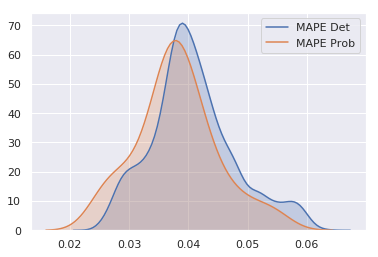

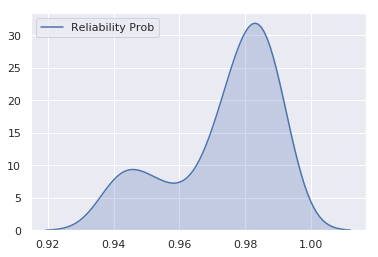

In [74]:
forecasts_path="/lustre/eaglefs/projects/rjsolfor/NYISO/Load_Forecasts/Probabilistic/IntraDay"
zone_names=['CAPTIL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL','MILLWD', 'N.Y.C.', 'NORTH', 'WEST', 'NYISO_BA']
#zone_names=['NYISO_BA']
begin = time.time()
agg_det_metrics={"MAE":0,'RMSE':0,'MAPE':[],'MBE':0}
agg_prob_metrics={"MAE":0,'RMSE':0,'MAPE':[],'MBE':0,'CRPS':[],'Reliability':[]}
for z in zone_names:
    #z=zone_names[0]
    print(z)
    #gaussian z-score
    z_score=np.zeros((99,1))
    for i in range(1,100):
        a=i/100
        z_score[(i-1),]=scipy.stats.norm.ppf(a)
    #15min actuals
    a=[]
    zone=z
    for i in range(8844):
        a.append(zone_load_data1hour[zone][8671+i:8677+i].values)

    cols=[]
    dti=pd.date_range('2018-12-28 00:00:00',periods=8844, freq='1H')
    dti
    for i in range(7,13):
        cols.append("{}_n_steps_ahead".format(i))
    actual_1hour_load=pd.DataFrame(a,columns=cols, index=dti)
    var_max=max(actual_1hour_load["7_n_steps_ahead"])*.08/2.32 #.05 works well
    #load forecasts 
    cnn_data=[]
    rnn_data=[]
    det_metrics={"MAE":[],'RMSE':[],'MAPE':[],'MBE':[]}
    prob_metrics={"MAE":[],'RMSE':[],'MAPE':[],'MBE':[],'CRPS':[],'Reliability':[]}
    for i in range(0,51):
        try:
            cnn_data.append(pd.read_csv('/lustre/eaglefs/projects/rjsolfor/NYISO/Load_Forecasts/Deterministic/{}/6H_CNN_ECMWF{}_Forceast.csv'.format(zone,i),index_col=0))
            cnn_data[i].index=pd.to_datetime(pd.date_range('2018-12-28 00:00:00',periods=8856, freq='1H'))
        except:
            pass
        try:
            rnn_data.append(pd.read_csv('/lustre/eaglefs/projects/rjsolfor/NYISO/Load_Forecasts/Deterministic/{}/6H_RNN_ECMWF{}_Forceast.csv'.format(zone,i),index_col=0))
            rnn_data[i].index=pd.to_datetime(pd.date_range('2018-12-28 00:00:00',periods=8856, freq='1H'))
        except:
            pass
        for j in range(7,13):
            horizon='{}_n_steps_ahead'.format(j)
            #Metrics
            start='2018-12-28 00:00:00'
            end='2019-12-31 11:00:00'
            c=cnn_data[i][horizon].loc[start:end]
            r=rnn_data[i][horizon].loc[start:end]
            t=actual_1hour_load[horizon].loc[start:end]

            #MBE
            det_metrics['MBE'].append((t-c).mean())
            det_metrics['MBE'].append((t-r).mean())
            #MAE
            det_metrics['MAE'].append(abs(t-c).mean())
            det_metrics['MAE'].append(abs(t-r).mean())
            #RMSE
            det_metrics['RMSE'].append(np.sqrt(((t-c)**2).mean()))
            det_metrics['RMSE'].append(np.sqrt(((t-r)**2).mean()))
            #MAPE
            det_metrics['MAPE'].append(abs((t- c)/t).mean())
            det_metrics['MAPE'].append(abs((t- r)/t).mean())
    agg_det_metrics['MBE']=agg_det_metrics['MBE']+ np.mean(det_metrics['MBE'])
    agg_det_metrics['MAE']=agg_det_metrics['MAE']+ np.mean(det_metrics['MAE'])
    agg_det_metrics['RMSE']=agg_det_metrics['RMSE']+ np.mean(det_metrics['RMSE'])
    agg_det_metrics['MAPE'].extend(det_metrics['MAPE'])
    #this creates the dataframe for probabalistic horizon forecast 
    columns=['0.01']
    fil=0.01
    for k in range(98):
        fil=round(fil+.01,2)
        columns.append('{}'.format(fil))
    prob_forecast=pd.DataFrame(columns=columns, index=rnn_data[0].index)
    #below loop cycles through each horizon to create prob forecast
    #h=5
    horizon_count=0
    for c in actual_1hour_load.columns:
        var_percent=1/((var_max*.0037317)+(8.087-.1*horizon_count)) #.00037317
        horizon=c
        #number of ensemble members
        m_c=len(cnn_data)
        m_r=len(rnn_data)
        total_ensem=m_c+m_r
        #number of timesteps
        n=rnn_data[0].shape[0]
        #forecasts matrix and weights
        forecast_matrix=np.zeros((n,total_ensem))
        weights=np.ones(total_ensem)

        #creates a inidvidual forecast matrix for the horizon
        for i in range(0,m_c):
            forecast_matrix[:,i]=cnn_data[i][horizon]
        e_mem=0
        for j in range(m_c,total_ensem):
            forecast_matrix[:,j]=rnn_data[e_mem][horizon]
            e_mem=e_mem+1
    #         window_forecast=[]
    #         window_actual=[]
        #loop cycles through each timestep to calculate mu and var for gaussian estimate
        for k in range(n):
            #each time steps weight adjustment
            det_point_forecast=forecast_matrix[k,:]
            mu=det_point_forecast @ weights/sum(weights)
            cnn_var=np.std(det_point_forecast[0:m_c])**2
            rnn_var=np.std(det_point_forecast[m_c:total_ensem])**2
            var=(cnn_var+rnn_var)/2
            if(var>var_max):
                var=max(det_point_forecast)*var_percent/2.32
            #Variance.append(var)
            prob_point_forecast=mu+z_score*var
            #weighted probabalistic forecast
            prob_forecast.iloc[k]=prob_point_forecast.reshape(99)
            #accuracy of forecast
    #             if(k>h):
    #                 window_forecast.append(mu)
    #                 window_actual.append(actual_15min_load[horizon].values[k])
    #             if(window_forecast):
        horizon_count=horizon_count+1        

        # base dir
        _dir = forecasts_path       

        # create dynamic name, like "D:\Current Download\Attachment82673"
        _dir = os.path.join(_dir, '{}'.format(z))

        # create 'dynamic' dir, if it does not exist
        if not os.path.exists(_dir):
            os.makedirs(_dir)
        #save each horizon
        prob_forecast.to_csv(forecasts_path + '/{}/{}_Prob_Forceast.csv'.format(z,horizon))
        upper = np.array(prob_forecast['0.99'], dtype=float)
        lower = np.array(prob_forecast['0.01'], dtype=float)
        center = np.array(prob_forecast['0.5'].head(8844), dtype=float)
        count=0
        for r in range(actual_1hour_load[horizon].shape[0]):
            if((actual_1hour_load[horizon].values[r]>lower[r]) & (actual_1hour_load[horizon].values[r]<upper[r])):
                count=count+1
        reliability=count/prob_forecast.shape[0]
        crps=CRPS(actual_1hour_load[horizon].values,prob_forecast)
        prob_metrics['Reliability'].append(reliability)
        prob_metrics['CRPS'].append(crps)
        t=actual_1hour_load[horizon].loc[start:end]

        #MBE
        prob_metrics['MBE'].append((t-center).mean())
        #MAE
        prob_metrics['MAE'].append(abs(t-center).mean())
        #RMSE
        prob_metrics['RMSE'].append(np.sqrt(((t-center)**2).mean()))
        #MAPE
        prob_metrics['MAPE'].append(abs((t- center)/t).mean())
        
    agg_prob_metrics['MBE']=agg_prob_metrics['MBE']+ np.mean(prob_metrics['MBE'])
    agg_prob_metrics['MAE']=agg_prob_metrics['MAE']+ np.mean(prob_metrics['MAE'])
    agg_prob_metrics['RMSE']=agg_prob_metrics['RMSE']+ np.mean(prob_metrics['RMSE'])
    agg_prob_metrics['MAPE'].extend(prob_metrics['MAPE'])
    agg_prob_metrics['Reliability'].extend(prob_metrics['Reliability'])

#     plt.figure()
#     sns.kdeplot(det_metrics['MBE'], shade=True, label='MBE Det')
#     sns.kdeplot(prob_metrics['MBE'], shade=True, label='MBE Prob')
#     plt.show()  

#     plt.figure()
#     sns.kdeplot(det_metrics['MAE'], shade=True, label='MAE Det')
#     sns.kdeplot(prob_metrics['MAE'], shade=True, label='MAE Prob')
#     plt.show()
#     plt.figure()
#     sns.kdeplot(det_metrics['RMSE'], shade=True, label='RMSE Det')
#     sns.kdeplot(prob_metrics['RMSE'], shade=True, label='RMSE Prob')
#     plt.show()
#     plt.figure()
#     sns.kdeplot(det_metrics['MAPE'], shade=True, label='MAPE Det')
#     sns.kdeplot(prob_metrics['MAPE'], shade=True, label='MAPE Prob')
#     plt.show()
#     plt.figure()
#     sns.kdeplot(prob_metrics['CRPS'], shade=True, label='CRPS Prob')
#     plt.show()
#     plt.figure()
#     sns.kdeplot(prob_metrics['Reliability'], shade=True, label='Reliability Prob')
#     plt.show()
end = time.time()
print('time elapsed:{}'.format(end - begin))
print('Det forecast total MBE:{}'.format(agg_det_metrics['MBE']))
print('Prob forecast total MBE:{}'.format(agg_prob_metrics['MBE']))
print('Det forecast total MAE:{}'.format(agg_det_metrics['MAE']))
print('Prob forecast total MAE:{}'.format(agg_prob_metrics['MAE']))
print('Det forecast total RMSE:{}'.format(agg_det_metrics['RMSE']))
print('Prob forecast total RMSE:{}'.format(agg_prob_metrics['RMSE']))
plt.figure()
sns.kdeplot(agg_det_metrics['MAPE'], shade=True, label='MAPE Det')
sns.kdeplot(agg_prob_metrics['MAPE'], shade=True, label='MAPE Prob')
plt.show()
plt.figure()
sns.kdeplot(agg_prob_metrics['Reliability'], shade=True, label='Reliability Prob')
plt.show()

In [7]:
## Organizing data to for deliverables


'/lustre/eaglefs/projects/rjsolfor/NYISO/HPC_Scripts'

In [20]:
#Grabs only issue time forecasts and organized deliveribles and saves csv file
zone_names=['CAPTIL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL','MILLWD', 'N.Y.C.', 'NORTH', 'WEST', 'NYISO_BA']
deliv_path='/lustre/eaglefs/projects/rjsolfor/NYISO/Deliverables/Intra-day'
for z in zone_names:
    #z=zone_names[0]
    print(z)
    #15min actuals
    zone_load_data1hour[z]

    horizons = {}
    actuals=zone_load_data1hour[z]


    for i in range(7,13):
        #print(i)
        s=pd.read_csv(r'/lustre/eaglefs/projects/rjsolfor/NYISO/Load_Forecasts/Probabilistic/IntraDay/{}/{}_n_steps_ahead_Prob_Forceast.csv'.format(z,i), index_col=0)
        horizons["T{}".format(i)] = s

    #this creates the data frame to compare the true values
    f_columns=['0.01']
    fil=0.01
    for k in range(98):
        fil=round(fil+.01,2)
        f_columns.append('{}'.format(fil))

    prob_forecast = np.zeros(shape=(8766,99))
    a = np.zeros(shape=(8766,1))
    count=0
    issue_time_index = pd.date_range('2018-12-31 17:00:00+00:00', periods=1461, freq='6H')
    issue_time=[]
    horizon_time=[]
    for d in issue_time_index:
        #indx=(6*d)+4

        for i in range(7,13):
    #         temp=horizons['T{}'.format(i)].iloc[indx,].name
            issue_time.append(d.strftime("%Y-%m-%d %H:%M:00"))
            dti = pd.date_range(d, periods=12, freq='1H')
            horizon_time.append(dti[i-1])
            try:
                a[count]=actuals[dti[i-1]]
            except:
                pass


            prob_forecast[count,]=horizons['T{}'.format(i)].loc[d.strftime("%Y-%m-%d %H:%M:00")].values
            count=count+1

    forecast_df=pd.DataFrame(data=prob_forecast,columns=f_columns)
    forecast_df['Issue_Time']=issue_time
    forecast_df['Horizon_Time']=horizon_time
    forecast_df['Actuals']=a

    cols = forecast_df.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    forecast_df=forecast_df[cols]
    forecast_df=forecast_df.set_index('Issue_Time')
    forecast_df=forecast_df.tail(-1)
    forecast_df=forecast_df.head(-5)

    # base dir
    _dir = deliv_path       

    # create dynamic name, like "D:\Current Download\Attachment82673"
    if(z=='NYISO_BA'):
        folder='BA_level'
    else:
        folder='Zone_level'
    _dir = os.path.join(_dir, '{}'.format(folder))

    # create 'dynamic' dir, if it does not exist
    if not os.path.exists(_dir):
        os.makedirs(_dir)

    forecast_df.to_csv(deliv_path + '/{}/{}_fcst_2019.csv'.format(folder,z))

CAPTIL


/home/rringja/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.


CENTRL
DUNWOD
GENESE
HUD VL
LONGIL
MHK VL
MILLWD
N.Y.C.
NORTH
WEST
NYISO_BA


In [122]:
#saving .h5 file types

In [22]:
zone_names=['CAPTIL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL', 'MHK VL','MILLWD', 'N.Y.C.', 'NORTH', 'WEST', 'NYISO_BA']
# horizon=['Intra-day','Intra-hour', 'Day-ahead']
# for h in horizon:
h='Intra-day'
for z in zone_names:
    #forecast=pd.read_csv(r'/Users/rringja/Documents/GitHub/Global-Energy-Forecasting-Competition-2014/Final_Forecast_Data/Deliverables/{}/BA_level/BA_Forecast.csv'.format(h), index_col=0)
    if(z=='NYISO_BA'):
        folder='BA_level'
    else:
        folder='Zone_level'
    forecast=pd.read_csv(r'/lustre/eaglefs/projects/rjsolfor/NYISO/Deliverables/{}/{}/{}_fcst_2019.csv'.format(h,folder,z), index_col=0)


    issue_time = forecast.index.values.astype(str)
    dtype = "S{}".format(len(issue_time[0]))
    issue_time = np.array(issue_time, dtype=dtype)

    forecast=forecast.set_index('Horizon_Time')

    horizon_time = forecast.index.values.astype(str)
    dtype = "S{}".format(len(horizon_time[0]))
    horizon_time = np.array(horizon_time, dtype=dtype)


    actuals = forecast['Actuals'].values.astype('float32') # you don't need 64 bit precision
    forecast=forecast.drop('Actuals',axis=1)

    forecast = forecast.values.astype('float32') # you don't need 64 bit precision
    meta=[folder,'UTC_timezone']
    asciiList = [n.encode("ascii", "ignore") for n in meta]

    with h5py.File('/lustre/eaglefs/projects/rjsolfor/NYISO/Deliverables/{}/{}/{}_fcst_2019.h5'.format(h,folder,z), mode='a') as f:
        # Create issue_time
        f.create_dataset('issue_time', shape=issue_time.shape, dtype=issue_time.dtype, data=issue_time)
        # Create horizon_time
        f.create_dataset('forecast_time', shape=horizon_time.shape, dtype=horizon_time.dtype, data=horizon_time)
        # Create forecasts
        f.create_dataset('forecasts', shape=forecast.shape, dtype=forecast.dtype, data=forecast)
        f.create_dataset('meta', shape=(len(asciiList),1), dtype='S10', data=asciiList)
    f.close()
    
#     for z in zone:
#         #z='West'
#         forecast=pd.read_csv(r'/Users/rringja/Desktop/Gaussian_Rework/ERCOT_Load/{}/Zone_level/{}_Forecast.csv'.format(h,z), index_col=0)

#         issue_time = forecast.index.values.astype(str)
#         dtype = "S{}".format(len(issue_time[0]))
#         issue_time = np.array(issue_time, dtype=dtype)

#         forecast=forecast.set_index('Horizon_Time')

#         horizon_time = forecast.index.values.astype(str)
#         dtype = "S{}".format(len(horizon_time[0]))
#         horizon_time = np.array(horizon_time, dtype=dtype)


#         actuals = forecast['Actuals'].values.astype('float32') # you don't need 64 bit precision
#         forecast=forecast.drop('Actuals',axis=1)

#         forecast = forecast.values.astype('float32') # you don't need 64 bit precision
#         meta=['{}'.format(z),'UTC']
#         asciiList = [n.encode("ascii", "ignore") for n in meta]

#         with h5py.File('/Users/rringja/Desktop/Gaussian_Rework/deliverables3/{}/Zone_level/Zone_{}_load_{}_fcst_2018.h5'.format(h,z,h.lower()), mode='a') as f:
#             # Create issue_time
#             f.create_dataset('issue_time', shape=issue_time.shape, dtype=issue_time.dtype, data=issue_time)
#             # Create horizon_time
#             f.create_dataset('forecast_time', shape=horizon_time.shape, dtype=horizon_time.dtype, data=horizon_time)
#             # Create forecasts
#             f.create_dataset('forecasts', shape=forecast.shape, dtype=forecast.dtype, data=forecast)
#             f.create_dataset('meta', shape=(len(asciiList),1), dtype='S10', data=asciiList)
#         f.close()


